# Traditional Dual Momentum

### Assets: 
- S&P 500 = SPY
- ACWI ex U.S. = VEU : Vanguard FTSE All-World ex-US ETF
- Aggregate Bonds = BND : Vanguard Total Bond Market ETF
- 1-3 Month T Bills = BIL : SPDR Lehman 1-3 Month T Bill ETF

### Rules:
1. Strategy includes four ETF's. Three of them are meant for investment and the other is meant for comparison only (BIL).
2. Calculate the 12 month return for SPY and VEU. Select the ETF that has a better performance.
3. Compare selected ETF to the returns of BIL. If ETF > BIL then go long ETF. Else if ETF < BIL then go long BND.
4. Calculations and trades conducted at the end of every month.

https://roboticinvesting.com/2018/07/17/dual-momentum-rules-summary/

*Notes: Model does not have transaction costs built in

In [1]:
# Importing all the necessary packages we will use for our code
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import seaborn as sns
from scipy import stats
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
import yfinance as yf

# Allows entire DataFrame to be displayed when called
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
#List used for indicator generation
#EASIER IF IN ALPHABETICAL ORDER
symbols = ['BIL', 'BND', 'SPY', 'VEU']

#List used for rebalance criteria 
#EASIER IF IN ALPHABETICAL ORDER
assets = ['BIL', 'BND', 'SPY', 'VEU']

start_date = '2007-07-01'
end_date = '2022-07-08'
interval = '1d'

price = yf.download(symbols, start=start_date, end=end_date, interval=interval)
price = price.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
price.columns = price.columns.droplevel(0)

#Renaming symbol columns to symbol_price (mandatory)
new_cols_list = ['BIL_Price', 'BND_Price', 'SPY_Price', 'VEU_Price']
price.columns = new_cols_list

price = price.dropna()
price.head()

[*********************100%***********************]  4 of 4 completed


,BIL_Price,BND_Price,SPY_Price,VEU_Price
Date,,,,
2007-07-02,84.075058,46.991173,112.918175,37.844818
2007-07-03,84.075058,46.896183,113.327324,38.266640
2007-07-05,84.075058,46.706253,113.208267,38.220497
2007-07-06,84.111771,46.611324,113.803406,38.484127
2007-07-09,84.130096,46.661987,113.892685,38.741177


In [3]:
#Indicator and Signal 

#12 Month Return
for symbol in symbols:
    price[str(symbol) + '_ROC'] = ((price[symbol + '_Price'].shift(1) / price[symbol + '_Price'].shift(253)) - 1)
    
price = price.dropna()
price.head()

,BIL_Price,BND_Price,SPY_Price,VEU_Price,BIL_ROC,BND_ROC,SPY_ROC,VEU_ROC
Date,,,,,,,,
2008-07-02,86.718475,50.126957,95.758415,34.339725,0.031441,0.070399,-0.137180,-0.080320
2008-07-03,86.718475,50.166744,95.857086,34.306492,0.031441,0.068892,-0.155028,-0.102620
2008-07-07,86.699539,50.193230,94.878113,34.060493,0.031441,0.074091,-0.153268,-0.102406
2008-07-08,86.661705,50.478184,96.562836,34.273251,0.030766,0.076846,-0.166298,-0.114947
2008-07-09,86.680618,50.484837,94.703568,33.741371,0.030092,0.081784,-0.152159,-0.115328


In [4]:
#Creating a dataframe of daily returns 
ret = price[['BIL_Price', 'BND_Price', 'SPY_Price', 'VEU_Price']].pct_change()
ret.columns = assets
ret = ret.dropna()
ret.head()

,BIL,BND,SPY,VEU
Date,,,,
2008-07-03,0.000000,0.000794,0.001030,-0.000968
2008-07-07,-0.000218,0.000528,-0.010213,-0.007171
2008-07-08,-0.000436,0.005677,0.017757,0.006246
2008-07-09,0.000218,0.000132,-0.019254,-0.015519
2008-07-10,0.000873,0.002757,0.004087,0.010443


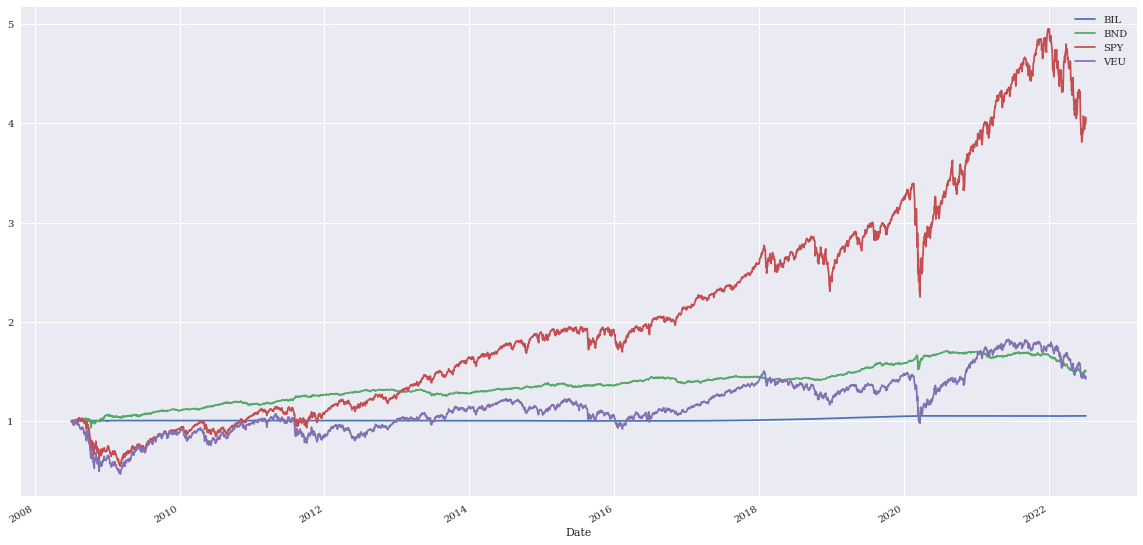

In [5]:
ret.add(1).cumprod().plot(figsize=(20,10))

In [6]:
#Getting rebalance dates 

#END OF MONTH

rebal = pd.DataFrame(index=price.index)
rebal['Rebal'] = price.index
rebal['Bool'] = np.where(rebal['Rebal'].dt.month == rebal['Rebal'].dt.month.shift(-1), False, True)
rebal = rebal[rebal.Bool == True]
rebal.head()

,Rebal,Bool
Date,,
2008-07-31,2008-07-31,True
2008-08-29,2008-08-29,True
2008-09-30,2008-09-30,True
2008-10-31,2008-10-31,True
2008-11-28,2008-11-28,True


In [7]:
def select_assets(rb_date):
    positions = []
    
    if price['SPY_ROC'][rb_date] > price['VEU_ROC'][rb_date]:
        if price['SPY_ROC'][rb_date] > price['BIL_ROC'][rb_date]:
            positions.append('SPY')
        else:
            positions.append('BND')
    elif price['SPY_ROC'][rb_date] < price['VEU_ROC'][rb_date]:
        if price['VEU_Price'][rb_date] > price['BIL_ROC'][rb_date]:
            positions.append('VEU')
        else:
            positions.append('BND')
    
    print("Assets to go Long:\n", positions)
    return positions

def calc_returns(positions, rb_date, next_rb_date):
    print('Position Returns:\n', ret.loc[rb_date:next_rb_date,positions][1:].add(1).cumprod())
    return ret.loc[rb_date:next_rb_date,positions][1:].add(1).cumprod()

def rebalance(old_portfolio , weights):
    dollar_size = (weights * old_portfolio.sum())
    print('Dollar Weights:\n', dollar_size)
    return  dollar_size 

def calc_weights(positions, rb_date):
    weights = pd.Series(1.0, index=positions)
    print('Target Allocation by %:\n', weights)
    return weights

def update_portfolio_value(portfolio_value, future_values):
    return pd.concat([portfolio_value, future_values.sum(axis=1)])

def get_rebalance_dates(start_delay=0):
    t = pd.DataFrame({'date' : rebal.index[start_delay:]})
    rebal_dates = rebal.index[start_delay:]
    future_days = rebal.index[1:]
    return zip(rebal_dates, future_days)

In [8]:
rebalance_dates = get_rebalance_dates()

In [9]:
def calculate_portfolio_ret():
    #Store to daily total value of the portfolio
    portfolio_value = pd.Series()
    
    #Starting cash amount in portfolio
    current_positions = pd.Series(10000)          

    for rb, rb_next in rebalance_dates:          # rb = rebalance date
        
        print(' \n-Rebalance: ', rb)
        positions  = select_assets(rb)  
        weights       = calc_weights(positions, rb)                    
        new_positions = rebalance(current_positions, weights)        
        cum_ret       = calc_returns(positions, rb, rb_next)
        future_values = cum_ret * new_positions                 
        portfolio_value = update_portfolio_value(portfolio_value, future_values)
        current_positions = future_values.iloc[-1]               # For next round  
           
    portfolio_return = portfolio_value.pct_change().to_frame('Portfolio')
    
    #Daily portfolio returns
    return portfolio_return     

In [10]:
pr = calculate_portfolio_ret()
pr

<ipython-input-9-c67902e346f5>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  portfolio_value = pd.Series()


 
-Rebalance:  2008-07-31 00:00:00
Assets to go Long:
 ['VEU']
Target Allocation by %:
 VEU    1.0
dtype: float64
Dollar Weights:
 VEU    10000.0
dtype: float64
Position Returns:
                  VEU
Date                
2008-08-01  0.989628
2008-08-04  0.973777
2008-08-05  0.994521
2008-08-06  0.997065
2008-08-07  0.976712
2008-08-08  0.975930
2008-08-11  0.976517
2008-08-12  0.966732
2008-08-13  0.956947
2008-08-14  0.954011
2008-08-15  0.944423
2008-08-18  0.934442
2008-08-19  0.928571
2008-08-20  0.937769
2008-08-21  0.943248
2008-08-22  0.945205
2008-08-25  0.931702
2008-08-26  0.931507
2008-08-27  0.943640
2008-08-28  0.952055
2008-08-29  0.948924
 
-Rebalance:  2008-08-29 00:00:00
Assets to go Long:
 ['BND']
Target Allocation by %:
 BND    1.0
dtype: float64
Dollar Weights:
 BND    9489.235296
dtype: float64
Position Returns:
                  BND
Date                
2008-09-02  1.003262
2008-09-03  1.004578
2008-09-04  1.005105
2008-09-05  1.005894
2008-09-08  1.012998
2008-0

,Portfolio
2008-08-01,NaN
2008-08-04,-0.016017
2008-08-05,0.021303
2008-08-06,0.002558
2008-08-07,-0.020413
2008-08-08,-0.000801
2008-08-11,0.000601
2008-08-12,-0.010020
2008-08-13,-0.010122
2008-08-14,-0.003068


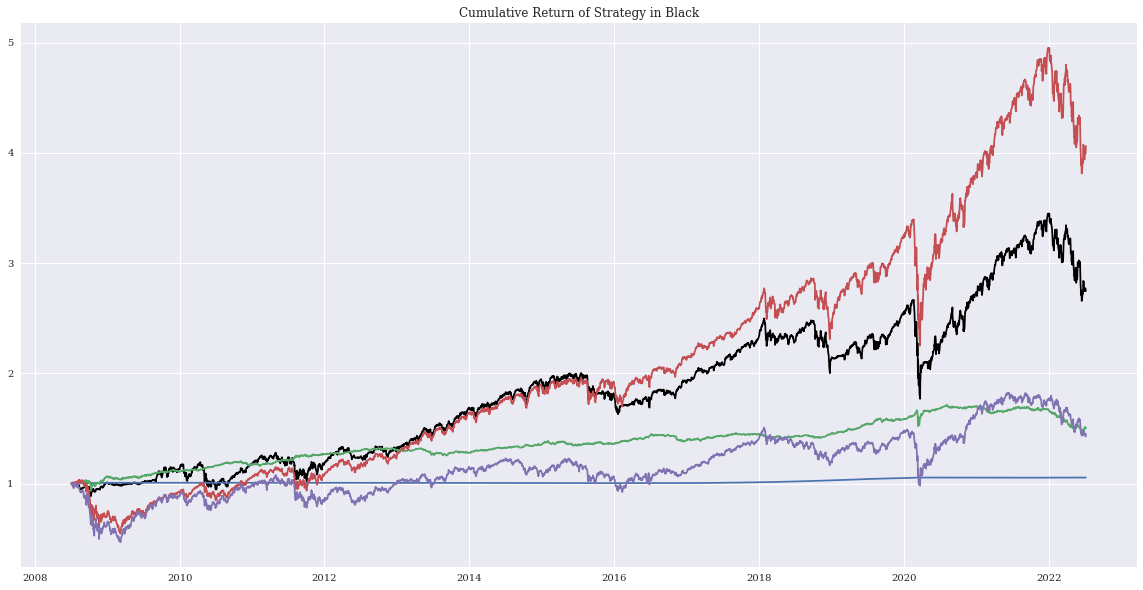

In [11]:
plt.figure(figsize=(20,10))
plt.plot(pr.add(1).cumprod(), color='black')
plt.plot(ret.add(1).cumprod())
plt.title("Cumulative Return of Strategy in Black");

In [12]:
#Performance Metrics

%matplotlib inline
import quantstats as qs

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2008-08-01  2008-08-01
End Period                 2022-07-07  2022-07-07
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          174.71%     306.28%
CAGR﹪                     7.52%       10.58%

Sharpe                     0.51        0.59
Smart Sharpe               0.46        0.53
Sortino                    0.71        0.83
Smart Sortino              0.63        0.74
Sortino/√2                 0.5         0.58
Smart Sortino/√2           0.44        0.52
Omega                      1.11        1.11

Max Drawdown               -33.72%     -47.17%
Longest DD Days            686         850
Volatility (ann.)          16.91%      20.66%
R^2                        0.57        0.57
Calmar                     0.22        0.22
Skew                       -0.59       -0.09
Kurtosis                   12.08      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-20,2020-03-23,2020-12-01,285,-33.717262,-29.109766
2,2022-01-04,2022-06-16,2022-07-07,184,-23.009973,-21.493902
3,2010-04-15,2010-07-02,2011-01-12,272,-20.912209,-20.393726
4,2011-05-02,2011-10-03,2012-02-24,298,-20.113129,-18.565070
5,2018-01-29,2018-12-24,2019-12-16,686,-19.882647,-15.188576


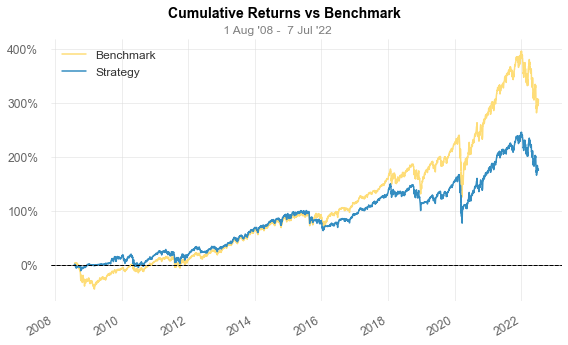

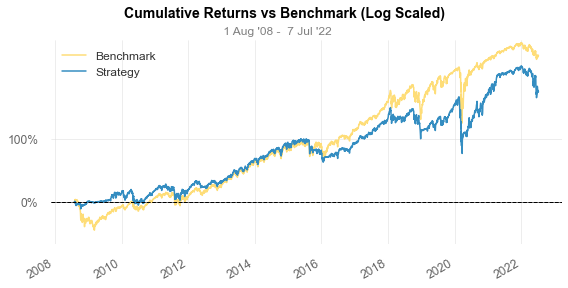

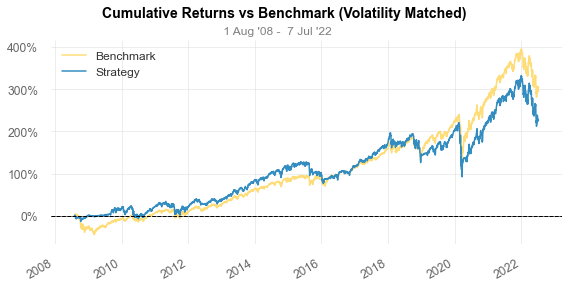

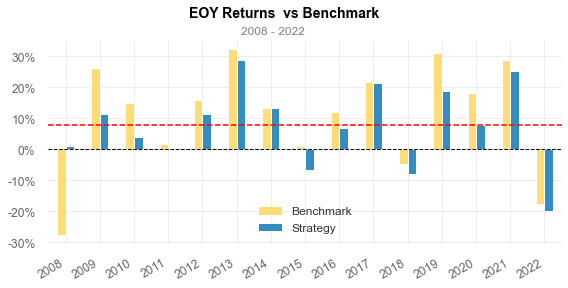

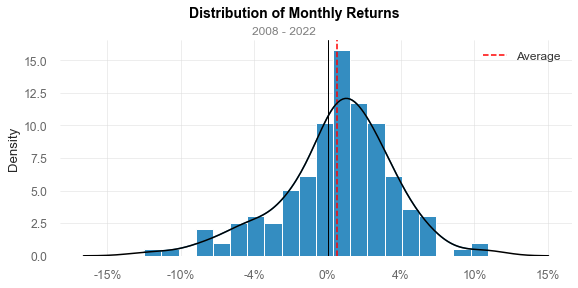

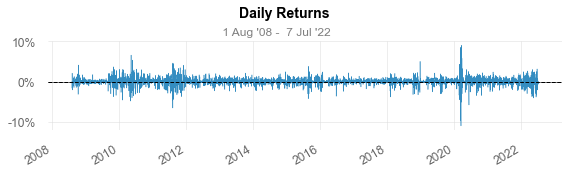

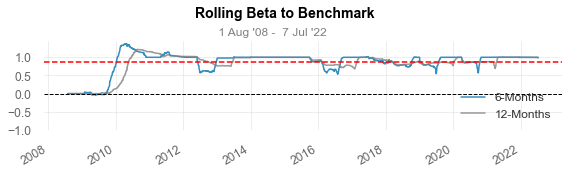

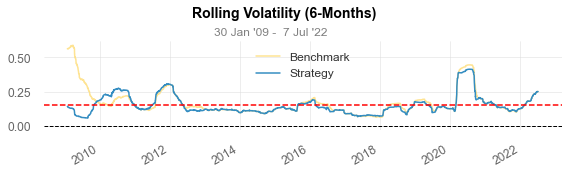

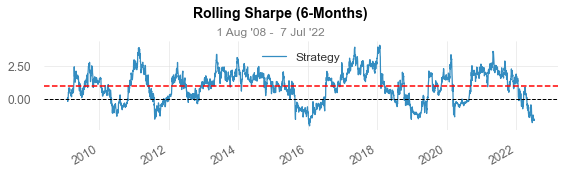

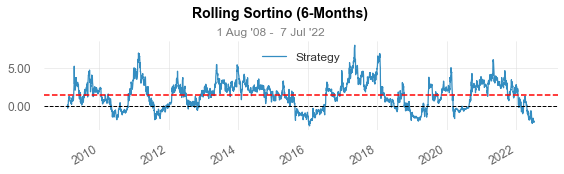

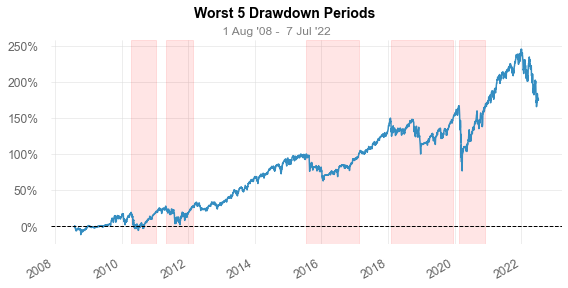

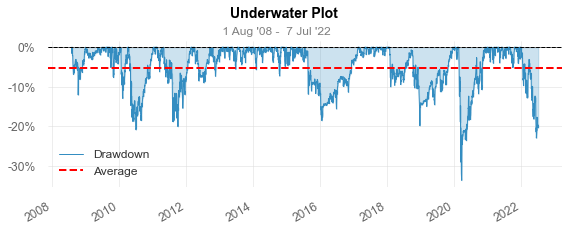

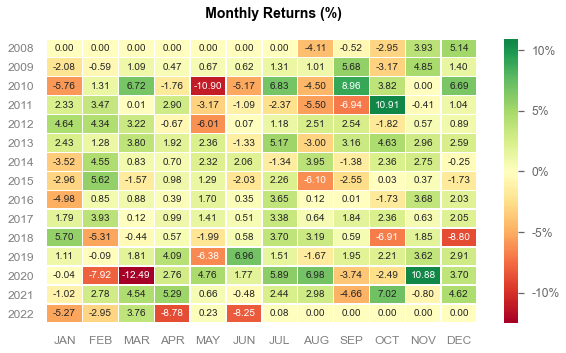

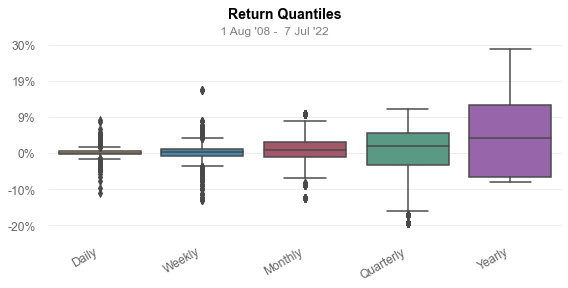

In [13]:
qs.reports.full(pr.Portfolio, "SPY")